In [ ]:
#!/usr/bin/env python3
"""
Colab-compatible CIFAR-10 training/evaluation (ResNet18), Mac GPU (MPS) ready.
- Uses Apple Metal (mps) if available
- Data augmentation: RandomCrop, Flip, AutoAugment
- Optional Mixup
- Label smoothing
- Cosine LR schedule with warmup
- SGD (momentum, Nesterov, weight decay)
- Checkpointing (latest + best)
- Resume support
"""

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import argparse
import random

# -------------------------
# Device helpers (MPS first on Mac)
# -------------------------
def resolve_device(preferred: str | None = None) -> torch.device:
    if preferred is not None:
        # allow explicit override via --device (cpu/cuda/mps)
        if preferred == "mps" and torch.backends.mps.is_available():
            return torch.device("mps")
        if preferred == "cuda" and torch.cuda.is_available():
            return torch.device("cuda")
        return torch.device("cpu")
    # auto-pick
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

# -------------------------
# Reproducibility helper
# -------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# -------------------------
# Model: Basic Residual Block and ResNet
# -------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Identity()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CIFARResNet(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[2,2,2,2], num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))        # (B,64,32,32)
        out = self.layer1(out)                       # (B,64,32,32)
        out = self.layer2(out)                       # (B,128,16,16)
        out = self.layer3(out)                       # (B,256,8,8)
        out = self.layer4(out)                       # (B,512,4,4)
        out = self.avgpool(out)                      # (B,512,1,1)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# -------------------------
# Mixup utilities
# -------------------------
def mixup_data(x, y, alpha=1.0, device=None):
    if alpha <= 0:
        return x, y, y, 1.0
    if device is None:
        device = x.device
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# -------------------------
# LR Scheduler with warmup + cosine decay
# -------------------------
class WarmupCosineLRScheduler:
    def __init__(self, optimizer, base_lr, total_epochs, warmup_epochs=5, min_lr=1e-5):
        self.optimizer = optimizer
        self.base_lr = base_lr
        self.total_epochs = total_epochs
        self.warmup_epochs = warmup_epochs
        self.min_lr = min_lr

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            lr = self.base_lr * float(epoch + 1) / max(1, self.warmup_epochs)
        else:
            decay_epochs = self.total_epochs - self.warmup_epochs
            pct = float(epoch - self.warmup_epochs) / max(1, decay_epochs)
            cosine = 0.5 * (1 + math.cos(math.pi * pct))
            lr = self.min_lr + (self.base_lr - self.min_lr) * cosine

        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr
        return lr

# -------------------------
# Train / Eval loops
# -------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, epoch, args, scheduler=None):
    model.train()
    running_loss, correct, total = 0.0, 0.0, 0
    for inputs, targets in tqdm(loader, desc=f"Train epoch {epoch}", leave=False):
        inputs = inputs.to(device, non_blocking=(device.type == "cuda"))
        targets = targets.to(device, non_blocking=(device.type == "cuda"))

        if args.mixup:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=args.mixup_alpha, device=device)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        if args.mixup:
            correct += lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item()
        else:
            correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in tqdm(loader, desc="Eval", leave=False):
        inputs = inputs.to(device, non_blocking=(device.type == "cuda"))
        targets = targets.to(device, non_blocking=(device.type == "cuda"))
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc

# -------------------------
# Checkpoint helpers
# -------------------------
def save_checkpoint(state, is_best, outdir, name="checkpoint.pth"):
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, name)
    torch.save(state, path)
    if is_best:
        torch.save(state, os.path.join(outdir, "best.pth"))

def accuracy_str(acc):
    return f"{acc:.2f}%"

# -------------------------
# Argument parsing (Colab/Mac-friendly)
# -------------------------
def get_args():
    parser = argparse.ArgumentParser(description="CIFAR-10 ResNet Training (MPS-ready)")
    parser.add_argument("--epochs", type=int, default=200)
    parser.add_argument("--batch-size", type=int, default=128)
    parser.add_argument("--lr", type=float, default=0.1)
    parser.add_argument("--weight-decay", type=float, default=5e-4)
    parser.add_argument("--momentum", type=float, default=0.9)
    parser.add_argument("--warmup-epochs", type=int, default=5)
    parser.add_argument("--mixup", action="store_true")
    parser.add_argument("--mixup-alpha", type=float, default=0.8)
    parser.add_argument("--label-smoothing", type=float, default=0.1)
    parser.add_argument("--data-dir", type=str, default="./data")
    parser.add_argument("--out-dir", type=str, default="./checkpoints")
    parser.add_argument("--resume", type=str, default=None, help="path to checkpoint to resume")
    parser.add_argument("--no-autoaugment", action="store_true", help="disable AutoAugment")

    # Default device prefers MPS on Mac, then CUDA, else CPU
    default_device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument("--device", type=str, default=default_device, choices=["cpu","cuda","mps"])
    args, _ = parser.parse_known_args()
    return args

# -------------------------
# Main
# -------------------------
def main():
    set_seed(42)
    args = get_args()
    device = resolve_device(args.device)
    print(f"Using device: {device}")

    # Data transforms
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2023, 0.1994, 0.2010)

    train_transforms = [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
    ]
    if not args.no_autoaugment:
        train_transforms.append(transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10))
    train_transforms += [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
    train_transform = transforms.Compose(train_transforms)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    # Dataset + loaders
    train_set = datasets.CIFAR10(root=args.data_dir, train=True, download=True, transform=train_transform)
    test_set = datasets.CIFAR10(root=args.data_dir, train=False, download=True, transform=test_transform)

    # Split train into train/val
    val_size = 5000
    train_size = len(train_set) - val_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_set, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    pin_mem = (device.type == "cuda")  # pin memory helps only for CUDA
    train_loader = DataLoader(train_subset, batch_size=args.batch_size, shuffle=True,
                              num_workers=4, pin_memory=pin_mem)
    val_loader = DataLoader(val_subset, batch_size=args.batch_size, shuffle=False,
                            num_workers=4, pin_memory=pin_mem)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False,
                             num_workers=4, pin_memory=pin_mem)

    # Model
    model = CIFARResNet().to(device)

    # Criterion
    criterion = nn.CrossEntropyLoss(label_smoothing=args.label_smoothing) if not args.mixup else nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=args.lr,
                          momentum=args.momentum, weight_decay=args.weight_decay, nesterov=True)
    scheduler = WarmupCosineLRScheduler(optimizer, base_lr=args.lr,
                                       total_epochs=args.epochs,
                                       warmup_epochs=args.warmup_epochs,
                                       min_lr=1e-5)

    start_epoch = 0
    best_val_acc = 0.0

    # Resume checkpoint if given
    if args.resume and os.path.isfile(args.resume):
        ckpt = torch.load(args.resume, map_location=device)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optim_state"])
        start_epoch = ckpt["epoch"] + 1
        best_val_acc = ckpt.get("best_val_acc", 0.0)
        print(f"Resumed from {args.resume}: starting at epoch {start_epoch}, best val acc {best_val_acc:.2f}")

    # Training loop
    for epoch in range(start_epoch, args.epochs):
        current_lr = scheduler.step(epoch)
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer,
                                                criterion, device, epoch+1, args, scheduler)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        is_best = val_acc > best_val_acc
        if is_best:
            best_val_acc = val_acc

        save_checkpoint({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
            "args": vars(args),
        }, is_best, args.out_dir)

        print(f"[{epoch+1:03d}/{args.epochs}] LR={current_lr:.5f} "
              f"Train loss={round(train_loss,4):.4f} acc={train_acc:.2f}% | "
              f"Val loss={round(val_loss,4):.4f} acc={val_acc:.2f}% | "
              f"Best val={best_val_acc:.2f}%")

    # Final test eval using best checkpoint
    best_path = os.path.join(args.out_dir, "best.pth")
    if os.path.isfile(best_path):
        print("Loading best checkpoint for test evaluation.")
        ckpt = torch.load(best_path, map_location=device)
        model.load_state_dict(ckpt["model_state"])
    else:
        print("Best model not found; using last epoch model.")

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    print(f"TEST  loss={test_loss:.4f} acc={test_acc:.2f}%")

    # Optional: free MPS cache between large runs
    if device.type == "mps":
        try:
            torch.mps.empty_cache()
        except Exception:
            pass

if __name__ == "__main__":
    main()


Using device: mps


[001/200] LR=0.02000 Train loss=1.8168 acc=39.17% | Val loss=1.6472 acc=48.90% | Best val=48.90%


[002/200] LR=0.04000 Train loss=1.4748 acc=56.47% | Val loss=1.6314 acc=51.12% | Best val=51.12%


[003/200] LR=0.06000 Train loss=1.3016 acc=64.66% | Val loss=1.3004 acc=65.04% | Best val=65.04%


[004/200] LR=0.08000 Train loss=1.2134 acc=69.05% | Val loss=1.3090 acc=64.32% | Best val=65.04%


[005/200] LR=0.10000 Train loss=1.1561 acc=71.41% | Val loss=1.2805 acc=64.66% | Best val=65.04%


[006/200] LR=0.10000 Train loss=1.1034 acc=73.51% | Val loss=1.2321 acc=67.88% | Best val=67.88%


[007/200] LR=0.09999 Train loss=1.0659 acc=75.56% | Val loss=1.0919 acc=73.12% | Best val=73.12%


[008/200] LR=0.09997 Train loss=1.0402 acc=76.26% | Val loss=1.1053 acc=73.70% | Best val=73.70%


[009/200] LR=0.09994 Train loss=1.0252 acc=77.04% | Val loss=1.1651 acc=70.76% | Best val=73.70%


[010/200] LR=0.09990 Train loss=1.0189 acc=77.44% | Val loss=1.0972 acc=74.48% | Best val=74.48%


[011/200] LR=0.09984 Train loss=1.0022 acc=78.00% | Val loss=1.0702 acc=74.86% | Best val=74.86%


[012/200] LR=0.09977 Train loss=0.9944 acc=78.50% | Val loss=1.0376 acc=76.00% | Best val=76.00%


[013/200] LR=0.09968 Train loss=0.9868 acc=78.76% | Val loss=1.0295 acc=76.46% | Best val=76.46%


[014/200] LR=0.09959 Train loss=0.9822 acc=78.96% | Val loss=1.0913 acc=73.56% | Best val=76.46%


[015/200] LR=0.09948 Train loss=0.9709 acc=79.48% | Val loss=1.0905 acc=74.18% | Best val=76.46%


[016/200] LR=0.09935 Train loss=0.9712 acc=79.44% | Val loss=1.1206 acc=72.70% | Best val=76.46%


[017/200] LR=0.09922 Train loss=0.9700 acc=79.49% | Val loss=1.0450 acc=75.34% | Best val=76.46%


[018/200] LR=0.09907 Train loss=0.9583 acc=80.01% | Val loss=1.0987 acc=74.00% | Best val=76.46%


[019/200] LR=0.09891 Train loss=0.9534 acc=80.31% | Val loss=1.1707 acc=70.72% | Best val=76.46%


[020/200] LR=0.09873 Train loss=0.9518 acc=80.29% | Val loss=1.0698 acc=75.28% | Best val=76.46%


[021/200] LR=0.09855 Train loss=0.9478 acc=80.45% | Val loss=1.0961 acc=73.54% | Best val=76.46%


[022/200] LR=0.09835 Train loss=0.9475 acc=80.65% | Val loss=1.0649 acc=74.62% | Best val=76.46%


[023/200] LR=0.09814 Train loss=0.9399 acc=80.76% | Val loss=1.0553 acc=75.96% | Best val=76.46%


[024/200] LR=0.09791 Train loss=0.9380 acc=80.96% | Val loss=0.9981 acc=78.10% | Best val=78.10%


[025/200] LR=0.09768 Train loss=0.9259 acc=81.31% | Val loss=1.1050 acc=74.18% | Best val=78.10%


[026/200] LR=0.09743 Train loss=0.9279 acc=81.37% | Val loss=0.9948 acc=78.14% | Best val=78.14%


[027/200] LR=0.09717 Train loss=0.9317 acc=81.27% | Val loss=1.0640 acc=75.76% | Best val=78.14%


[028/200] LR=0.09689 Train loss=0.9230 acc=81.71% | Val loss=1.0860 acc=73.66% | Best val=78.14%


[029/200] LR=0.09661 Train loss=0.9255 acc=81.46% | Val loss=1.1130 acc=73.88% | Best val=78.14%


[030/200] LR=0.09631 Train loss=0.9247 acc=81.49% | Val loss=0.9609 acc=79.64% | Best val=79.64%


[031/200] LR=0.09600 Train loss=0.9175 acc=82.00% | Val loss=1.0591 acc=75.66% | Best val=79.64%


[032/200] LR=0.09568 Train loss=0.9224 acc=81.62% | Val loss=1.0903 acc=74.18% | Best val=79.64%


[033/200] LR=0.09534 Train loss=0.9160 acc=81.73% | Val loss=1.0469 acc=75.34% | Best val=79.64%


[034/200] LR=0.09500 Train loss=0.9134 acc=82.08% | Val loss=1.1764 acc=72.18% | Best val=79.64%


[035/200] LR=0.09464 Train loss=0.9086 acc=82.24% | Val loss=1.0900 acc=73.92% | Best val=79.64%


[036/200] LR=0.09427 Train loss=0.9057 acc=82.32% | Val loss=1.0151 acc=76.98% | Best val=79.64%


[037/200] LR=0.09389 Train loss=0.9090 acc=82.18% | Val loss=1.0237 acc=77.38% | Best val=79.64%


[038/200] LR=0.09350 Train loss=0.9090 acc=82.03% | Val loss=0.9665 acc=79.28% | Best val=79.64%


[039/200] LR=0.09310 Train loss=0.9026 acc=82.45% | Val loss=0.9824 acc=79.28% | Best val=79.64%


[040/200] LR=0.09269 Train loss=0.9041 acc=82.42% | Val loss=0.9709 acc=79.28% | Best val=79.64%


[041/200] LR=0.09226 Train loss=0.9007 acc=82.70% | Val loss=1.0776 acc=74.84% | Best val=79.64%


[042/200] LR=0.09182 Train loss=0.8982 acc=82.61% | Val loss=0.9961 acc=78.70% | Best val=79.64%


[043/200] LR=0.09138 Train loss=0.8947 acc=82.67% | Val loss=1.0358 acc=77.14% | Best val=79.64%


[044/200] LR=0.09092 Train loss=0.8956 acc=82.79% | Val loss=1.0012 acc=77.90% | Best val=79.64%


[045/200] LR=0.09045 Train loss=0.8978 acc=82.50% | Val loss=1.1108 acc=74.02% | Best val=79.64%


[046/200] LR=0.08997 Train loss=0.8965 acc=82.70% | Val loss=1.0005 acc=77.48% | Best val=79.64%


[047/200] LR=0.08948 Train loss=0.8911 acc=83.06% | Val loss=0.9602 acc=79.88% | Best val=79.88%


[048/200] LR=0.08898 Train loss=0.8934 acc=82.81% | Val loss=0.9589 acc=80.16% | Best val=80.16%


[049/200] LR=0.08848 Train loss=0.8899 acc=83.02% | Val loss=0.9681 acc=79.28% | Best val=80.16%


[050/200] LR=0.08796 Train loss=0.8870 acc=83.20% | Val loss=0.9689 acc=79.12% | Best val=80.16%


[051/200] LR=0.08743 Train loss=0.8891 acc=83.12% | Val loss=1.0289 acc=77.22% | Best val=80.16%


[052/200] LR=0.08689 Train loss=0.8833 acc=83.29% | Val loss=0.9970 acc=78.16% | Best val=80.16%


[053/200] LR=0.08634 Train loss=0.8790 acc=83.35% | Val loss=1.0415 acc=77.28% | Best val=80.16%


[054/200] LR=0.08578 Train loss=0.8841 acc=83.18% | Val loss=0.9740 acc=79.48% | Best val=80.16%


[055/200] LR=0.08521 Train loss=0.8802 acc=83.41% | Val loss=1.0168 acc=77.88% | Best val=80.16%


[056/200] LR=0.08464 Train loss=0.8760 acc=83.47% | Val loss=1.0049 acc=78.20% | Best val=80.16%


[057/200] LR=0.08405 Train loss=0.8771 acc=83.62% | Val loss=0.9954 acc=78.38% | Best val=80.16%


[058/200] LR=0.08346 Train loss=0.8696 acc=83.94% | Val loss=0.9850 acc=78.64% | Best val=80.16%


[059/200] LR=0.08286 Train loss=0.8702 acc=83.90% | Val loss=0.9433 acc=80.38% | Best val=80.38%


[060/200] LR=0.08224 Train loss=0.8741 acc=83.76% | Val loss=1.0096 acc=77.62% | Best val=80.38%


[061/200] LR=0.08162 Train loss=0.8746 acc=83.62% | Val loss=0.9425 acc=80.26% | Best val=80.38%


[062/200] LR=0.08100 Train loss=0.8700 acc=83.87% | Val loss=1.0357 acc=76.18% | Best val=80.38%


[063/200] LR=0.08036 Train loss=0.8654 acc=84.03% | Val loss=0.9424 acc=80.56% | Best val=80.56%


[064/200] LR=0.07972 Train loss=0.8657 acc=84.03% | Val loss=0.9779 acc=79.64% | Best val=80.56%


[065/200] LR=0.07906 Train loss=0.8630 acc=84.26% | Val loss=1.0310 acc=76.92% | Best val=80.56%


[066/200] LR=0.07841 Train loss=0.8582 acc=84.56% | Val loss=0.9554 acc=79.80% | Best val=80.56%


[067/200] LR=0.07774 Train loss=0.8582 acc=84.61% | Val loss=1.0869 acc=74.90% | Best val=80.56%


[068/200] LR=0.07707 Train loss=0.8588 acc=84.50% | Val loss=0.9445 acc=80.40% | Best val=80.56%


[069/200] LR=0.07638 Train loss=0.8543 acc=84.50% | Val loss=0.9292 acc=81.72% | Best val=81.72%


[070/200] LR=0.07570 Train loss=0.8553 acc=84.39% | Val loss=0.9559 acc=80.38% | Best val=81.72%


[071/200] LR=0.07500 Train loss=0.8545 acc=84.57% | Val loss=0.9589 acc=79.60% | Best val=81.72%


[072/200] LR=0.07430 Train loss=0.8523 acc=84.53% | Val loss=0.9577 acc=80.18% | Best val=81.72%


[073/200] LR=0.07359 Train loss=0.8486 acc=84.89% | Val loss=0.9387 acc=80.94% | Best val=81.72%


[074/200] LR=0.07288 Train loss=0.8530 acc=84.60% | Val loss=0.9471 acc=80.28% | Best val=81.72%


[075/200] LR=0.07216 Train loss=0.8484 acc=84.84% | Val loss=0.9459 acc=80.62% | Best val=81.72%


[076/200] LR=0.07144 Train loss=0.8482 acc=84.98% | Val loss=0.9758 acc=78.94% | Best val=81.72%


[077/200] LR=0.07071 Train loss=0.8452 acc=85.09% | Val loss=1.0113 acc=78.68% | Best val=81.72%


[078/200] LR=0.06997 Train loss=0.8414 acc=85.05% | Val loss=0.9232 acc=80.90% | Best val=81.72%


[079/200] LR=0.06923 Train loss=0.8398 acc=85.33% | Val loss=0.9428 acc=80.42% | Best val=81.72%


[080/200] LR=0.06848 Train loss=0.8397 acc=85.13% | Val loss=0.9258 acc=81.36% | Best val=81.72%


[081/200] LR=0.06773 Train loss=0.8370 acc=85.30% | Val loss=0.9234 acc=81.60% | Best val=81.72%


[082/200] LR=0.06698 Train loss=0.8355 acc=85.41% | Val loss=0.9402 acc=80.86% | Best val=81.72%


[083/200] LR=0.06622 Train loss=0.8281 acc=85.85% | Val loss=0.9003 acc=82.60% | Best val=82.60%


[084/200] LR=0.06545 Train loss=0.8305 acc=85.55% | Val loss=0.9096 acc=81.72% | Best val=82.60%


[085/200] LR=0.06469 Train loss=0.8271 acc=85.83% | Val loss=0.9230 acc=82.12% | Best val=82.60%


[086/200] LR=0.06391 Train loss=0.8260 acc=85.84% | Val loss=0.9016 acc=82.58% | Best val=82.60%


[087/200] LR=0.06314 Train loss=0.8215 acc=86.06% | Val loss=0.9326 acc=81.44% | Best val=82.60%


[088/200] LR=0.06236 Train loss=0.8199 acc=86.15% | Val loss=0.9085 acc=81.34% | Best val=82.60%


[089/200] LR=0.06158 Train loss=0.8206 acc=86.03% | Val loss=0.8859 acc=83.08% | Best val=83.08%


[090/200] LR=0.06079 Train loss=0.8175 acc=86.24% | Val loss=0.9654 acc=78.92% | Best val=83.08%


[091/200] LR=0.06001 Train loss=0.8190 acc=86.14% | Val loss=0.9293 acc=81.64% | Best val=83.08%


[092/200] LR=0.05921 Train loss=0.8112 acc=86.63% | Val loss=0.8895 acc=83.22% | Best val=83.22%


[093/200] LR=0.05842 Train loss=0.8141 acc=86.29% | Val loss=0.8763 acc=83.38% | Best val=83.38%


[094/200] LR=0.05763 Train loss=0.8090 acc=86.60% | Val loss=0.9659 acc=79.80% | Best val=83.38%


[095/200] LR=0.05683 Train loss=0.8113 acc=86.54% | Val loss=0.8890 acc=82.82% | Best val=83.38%


[096/200] LR=0.05603 Train loss=0.8033 acc=86.78% | Val loss=0.8636 acc=84.32% | Best val=84.32%


[097/200] LR=0.05523 Train loss=0.8042 acc=86.86% | Val loss=1.0058 acc=77.50% | Best val=84.32%


[098/200] LR=0.05443 Train loss=0.8078 acc=86.70% | Val loss=0.9525 acc=80.36% | Best val=84.32%


[099/200] LR=0.05363 Train loss=0.8007 acc=86.95% | Val loss=0.9161 acc=81.90% | Best val=84.32%


[100/200] LR=0.05282 Train loss=0.8003 acc=86.93% | Val loss=0.8813 acc=83.04% | Best val=84.32%


[101/200] LR=0.05202 Train loss=0.7923 acc=87.33% | Val loss=0.9238 acc=81.18% | Best val=84.32%


[102/200] LR=0.05121 Train loss=0.7909 acc=87.29% | Val loss=0.8896 acc=83.54% | Best val=84.32%


[103/200] LR=0.05041 Train loss=0.7892 acc=87.41% | Val loss=0.8973 acc=82.82% | Best val=84.32%


[104/200] LR=0.04960 Train loss=0.7865 acc=87.57% | Val loss=0.8973 acc=83.42% | Best val=84.32%


[105/200] LR=0.04880 Train loss=0.7859 acc=87.45% | Val loss=0.8587 acc=84.18% | Best val=84.32%


[106/200] LR=0.04799 Train loss=0.7805 acc=87.92% | Val loss=0.8883 acc=83.10% | Best val=84.32%


[107/200] LR=0.04719 Train loss=0.7839 acc=87.70% | Val loss=0.9572 acc=80.40% | Best val=84.32%


[108/200] LR=0.04638 Train loss=0.7822 acc=87.71% | Val loss=0.8970 acc=83.32% | Best val=84.32%


[109/200] LR=0.04558 Train loss=0.7804 acc=87.86% | Val loss=0.9226 acc=82.02% | Best val=84.32%


[110/200] LR=0.04478 Train loss=0.7735 acc=88.24% | Val loss=0.8375 acc=84.84% | Best val=84.84%


[111/200] LR=0.04398 Train loss=0.7744 acc=88.17% | Val loss=0.9751 acc=79.58% | Best val=84.84%


[112/200] LR=0.04318 Train loss=0.7733 acc=87.98% | Val loss=0.9481 acc=80.52% | Best val=84.84%


[113/200] LR=0.04238 Train loss=0.7694 acc=88.14% | Val loss=0.8789 acc=83.28% | Best val=84.84%


[114/200] LR=0.04159 Train loss=0.7597 acc=88.72% | Val loss=0.8700 acc=84.28% | Best val=84.84%


[115/200] LR=0.04080 Train loss=0.7643 acc=88.41% | Val loss=0.9009 acc=82.02% | Best val=84.84%


[116/200] LR=0.04000 Train loss=0.7593 acc=88.65% | Val loss=0.9198 acc=82.22% | Best val=84.84%


[117/200] LR=0.03922 Train loss=0.7595 acc=88.68% | Val loss=0.8904 acc=82.92% | Best val=84.84%


[118/200] LR=0.03843 Train loss=0.7554 acc=88.83% | Val loss=0.8689 acc=84.66% | Best val=84.84%


[119/200] LR=0.03765 Train loss=0.7488 acc=89.22% | Val loss=0.9377 acc=81.64% | Best val=84.84%


[120/200] LR=0.03687 Train loss=0.7503 acc=89.10% | Val loss=0.8705 acc=83.64% | Best val=84.84%


[121/200] LR=0.03610 Train loss=0.7504 acc=89.13% | Val loss=0.8606 acc=84.08% | Best val=84.84%


[122/200] LR=0.03532 Train loss=0.7450 acc=89.42% | Val loss=0.8887 acc=83.46% | Best val=84.84%


[123/200] LR=0.03456 Train loss=0.7421 acc=89.36% | Val loss=0.8625 acc=84.02% | Best val=84.84%


[124/200] LR=0.03379 Train loss=0.7431 acc=89.44% | Val loss=0.8528 acc=84.84% | Best val=84.84%


[125/200] LR=0.03303 Train loss=0.7400 acc=89.50% | Val loss=0.8502 acc=84.66% | Best val=84.84%


[126/200] LR=0.03228 Train loss=0.7316 acc=90.01% | Val loss=0.8517 acc=84.44% | Best val=84.84%


[127/200] LR=0.03153 Train loss=0.7361 acc=89.84% | Val loss=0.8203 acc=86.00% | Best val=86.00%


[128/200] LR=0.03078 Train loss=0.7253 acc=90.28% | Val loss=0.8472 acc=85.06% | Best val=86.00%


[129/200] LR=0.03004 Train loss=0.7230 acc=90.42% | Val loss=0.8226 acc=86.02% | Best val=86.02%


[130/200] LR=0.02930 Train loss=0.7191 acc=90.49% | Val loss=0.8376 acc=85.30% | Best val=86.02%


[131/200] LR=0.02857 Train loss=0.7195 acc=90.48% | Val loss=0.8184 acc=86.42% | Best val=86.42%


[132/200] LR=0.02785 Train loss=0.7140 acc=90.75% | Val loss=0.8276 acc=85.64% | Best val=86.42%


[133/200] LR=0.02713 Train loss=0.7117 acc=90.86% | Val loss=0.8570 acc=84.48% | Best val=86.42%


[134/200] LR=0.02642 Train loss=0.7104 acc=90.81% | Val loss=0.8217 acc=85.88% | Best val=86.42%


[135/200] LR=0.02571 Train loss=0.7100 acc=90.92% | Val loss=0.8203 acc=86.04% | Best val=86.42%


[136/200] LR=0.02501 Train loss=0.7107 acc=90.88% | Val loss=0.7891 acc=87.28% | Best val=87.28%


[137/200] LR=0.02431 Train loss=0.7039 acc=91.17% | Val loss=0.8377 acc=85.56% | Best val=87.28%


[138/200] LR=0.02363 Train loss=0.6974 acc=91.49% | Val loss=0.8219 acc=85.86% | Best val=87.28%


[139/200] LR=0.02294 Train loss=0.6946 acc=91.56% | Val loss=0.7992 acc=86.86% | Best val=87.28%


[140/200] LR=0.02227 Train loss=0.6880 acc=91.84% | Val loss=0.8140 acc=86.24% | Best val=87.28%


[141/200] LR=0.02160 Train loss=0.6924 acc=91.65% | Val loss=0.8115 acc=86.78% | Best val=87.28%


[142/200] LR=0.02095 Train loss=0.6851 acc=91.97% | Val loss=0.7871 acc=87.58% | Best val=87.58%


[143/200] LR=0.02029 Train loss=0.6867 acc=91.90% | Val loss=0.8105 acc=86.22% | Best val=87.58%


[144/200] LR=0.01965 Train loss=0.6784 acc=92.30% | Val loss=0.7871 acc=87.76% | Best val=87.76%


[145/200] LR=0.01901 Train loss=0.6780 acc=92.24% | Val loss=0.7904 acc=87.32% | Best val=87.76%


[146/200] LR=0.01839 Train loss=0.6738 acc=92.37% | Val loss=0.8095 acc=86.48% | Best val=87.76%


[147/200] LR=0.01777 Train loss=0.6720 acc=92.57% | Val loss=0.7875 acc=87.42% | Best val=87.76%


[148/200] LR=0.01715 Train loss=0.6622 acc=93.00% | Val loss=0.7818 acc=88.18% | Best val=88.18%


[149/200] LR=0.01655 Train loss=0.6642 acc=92.91% | Val loss=0.7693 acc=88.30% | Best val=88.30%


[150/200] LR=0.01596 Train loss=0.6603 acc=93.03% | Val loss=0.7752 acc=88.08% | Best val=88.30%


[151/200] LR=0.01537 Train loss=0.6576 acc=93.16% | Val loss=0.7893 acc=87.24% | Best val=88.30%


[152/200] LR=0.01480 Train loss=0.6541 acc=93.32% | Val loss=0.7668 acc=88.44% | Best val=88.44%


[153/200] LR=0.01423 Train loss=0.6458 acc=93.73% | Val loss=0.7625 acc=88.58% | Best val=88.58%


[154/200] LR=0.01367 Train loss=0.6453 acc=93.63% | Val loss=0.7775 acc=88.30% | Best val=88.58%


[155/200] LR=0.01312 Train loss=0.6453 acc=93.73% | Val loss=0.7565 acc=88.82% | Best val=88.82%


[156/200] LR=0.01258 Train loss=0.6369 acc=94.10% | Val loss=0.7398 acc=89.58% | Best val=89.58%


[157/200] LR=0.01205 Train loss=0.6363 acc=94.20% | Val loss=0.7439 acc=89.92% | Best val=89.92%


[158/200] LR=0.01153 Train loss=0.6342 acc=94.23% | Val loss=0.7770 acc=88.50% | Best val=89.92%


[159/200] LR=0.01103 Train loss=0.6332 acc=94.22% | Val loss=0.7531 acc=88.76% | Best val=89.92%


[160/200] LR=0.01053 Train loss=0.6269 acc=94.53% | Val loss=0.7376 acc=89.62% | Best val=89.92%


[161/200] LR=0.01004 Train loss=0.6210 acc=94.77% | Val loss=0.7309 acc=90.24% | Best val=90.24%


[162/200] LR=0.00956 Train loss=0.6225 acc=94.76% | Val loss=0.7382 acc=90.02% | Best val=90.24%


[163/200] LR=0.00909 Train loss=0.6172 acc=94.96% | Val loss=0.7488 acc=89.76% | Best val=90.24%


[164/200] LR=0.00863 Train loss=0.6143 acc=95.14% | Val loss=0.7372 acc=89.74% | Best val=90.24%


[165/200] LR=0.00819 Train loss=0.6123 acc=95.11% | Val loss=0.7287 acc=90.18% | Best val=90.24%


[166/200] LR=0.00775 Train loss=0.6093 acc=95.29% | Val loss=0.7416 acc=89.70% | Best val=90.24%


[167/200] LR=0.00732 Train loss=0.6080 acc=95.36% | Val loss=0.7261 acc=90.38% | Best val=90.38%


[168/200] LR=0.00691 Train loss=0.6042 acc=95.57% | Val loss=0.7216 acc=90.70% | Best val=90.70%


[169/200] LR=0.00651 Train loss=0.5988 acc=95.74% | Val loss=0.7139 acc=90.90% | Best val=90.90%


[170/200] LR=0.00612 Train loss=0.5989 acc=95.74% | Val loss=0.7153 acc=90.84% | Best val=90.90%


[171/200] LR=0.00574 Train loss=0.5931 acc=96.00% | Val loss=0.7125 acc=91.02% | Best val=91.02%


[172/200] LR=0.00537 Train loss=0.5932 acc=96.00% | Val loss=0.7165 acc=90.82% | Best val=91.02%


[173/200] LR=0.00501 Train loss=0.5882 acc=96.27% | Val loss=0.6934 acc=91.96% | Best val=91.96%


[174/200] LR=0.00467 Train loss=0.5872 acc=96.28% | Val loss=0.6950 acc=91.70% | Best val=91.96%


[175/200] LR=0.00433 Train loss=0.5840 acc=96.40% | Val loss=0.6959 acc=91.36% | Best val=91.96%


[176/200] LR=0.00401 Train loss=0.5793 acc=96.59% | Val loss=0.6984 acc=91.78% | Best val=91.96%


[177/200] LR=0.00370 Train loss=0.5788 acc=96.64% | Val loss=0.7088 acc=91.08% | Best val=91.96%


[178/200] LR=0.00340 Train loss=0.5787 acc=96.63% | Val loss=0.6874 acc=92.36% | Best val=92.36%


[179/200] LR=0.00312 Train loss=0.5763 acc=96.66% | Val loss=0.6916 acc=91.98% | Best val=92.36%


[180/200] LR=0.00284 Train loss=0.5689 acc=97.07% | Val loss=0.7053 acc=91.26% | Best val=92.36%


[181/200] LR=0.00258 Train loss=0.5727 acc=96.91% | Val loss=0.6960 acc=91.54% | Best val=92.36%


[182/200] LR=0.00233 Train loss=0.5672 acc=97.16% | Val loss=0.6880 acc=92.12% | Best val=92.36%


[183/200] LR=0.00210 Train loss=0.5665 acc=97.19% | Val loss=0.6825 acc=92.34% | Best val=92.36%


[184/200] LR=0.00187 Train loss=0.5658 acc=97.24% | Val loss=0.6878 acc=91.90% | Best val=92.36%


[185/200] LR=0.00166 Train loss=0.5653 acc=97.10% | Val loss=0.6767 acc=92.56% | Best val=92.56%


[186/200] LR=0.00146 Train loss=0.5615 acc=97.38% | Val loss=0.6799 acc=92.52% | Best val=92.56%


[187/200] LR=0.00128 Train loss=0.5613 acc=97.41% | Val loss=0.6794 acc=92.50% | Best val=92.56%


[188/200] LR=0.00110 Train loss=0.5621 acc=97.36% | Val loss=0.6820 acc=92.30% | Best val=92.56%


[189/200] LR=0.00094 Train loss=0.5597 acc=97.45% | Val loss=0.6813 acc=92.52% | Best val=92.56%


[190/200] LR=0.00079 Train loss=0.5580 acc=97.53% | Val loss=0.6645 acc=92.96% | Best val=92.96%


[191/200] LR=0.00066 Train loss=0.5565 acc=97.60% | Val loss=0.6852 acc=92.16% | Best val=92.96%


[192/200] LR=0.00053 Train loss=0.5596 acc=97.46% | Val loss=0.6865 acc=92.60% | Best val=92.96%


[193/200] LR=0.00042 Train loss=0.5564 acc=97.62% | Val loss=0.6715 acc=92.62% | Best val=92.96%


[194/200] LR=0.00033 Train loss=0.5573 acc=97.56% | Val loss=0.6765 acc=92.42% | Best val=92.96%


[195/200] LR=0.00024 Train loss=0.5538 acc=97.75% | Val loss=0.6773 acc=92.64% | Best val=92.96%


[196/200] LR=0.00017 Train loss=0.5573 acc=97.46% | Val loss=0.6546 acc=93.62% | Best val=93.62%


[197/200] LR=0.00011 Train loss=0.5558 acc=97.57% | Val loss=0.6658 acc=93.08% | Best val=93.62%


[198/200] LR=0.00007 Train loss=0.5551 acc=97.65% | Val loss=0.6713 acc=92.88% | Best val=93.62%


[199/200] LR=0.00004 Train loss=0.5558 acc=97.60% | Val loss=0.6812 acc=92.44% | Best val=93.62%


[200/200] LR=0.00002 Train loss=0.5560 acc=97.60% | Val loss=0.6786 acc=92.32% | Best val=93.62%
Loading best checkpoint for test evaluation.


TEST  loss=0.6073 acc=95.77%


In [ ]:
import os, argparse
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ------------ CONFIG PARSER ------------
def get_args():
    p = argparse.ArgumentParser("Targeted FGSM & PGD (airplane -> horse)")
    p.add_argument("--ckpt", type=str, default="/Users/deeppandya/Desktop/Aple-silicon/checkpoints/best.pth")
    
    p.add_argument("--batch-size", type=int, default=128)
    p.add_argument("--eps", type=float, default=8, help="epsilon in /255")
    p.add_argument("--alpha", type=float, default=2, help="alpha in /255 for PGD")
    p.add_argument("--steps", type=int, default=10, help="PGD steps")
    p.add_argument("--maxviz", type=int, default=8, help="images per grid")
    p.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    return p.parse_args()

# ------------ CIFAR-10 CONSTANTS ------------
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
AIRPLANE, HORSE = 0, 7

# These will be created on the chosen device later:
MEAN = None
STD  = None

# ------------ NORMALIZE / DENORMALIZE ------------
def normalize(x):   # x in [0,1]
    return (x - MEAN) / STD

def denormalize(x):  # clip back to [0,1]
    return torch.clamp(x * STD + MEAN, 0.0, 1.0)

# ------------ LOADING MODEL ------------
def load_model(ckpt_path, device):
    model = CIFARResNet().to(device)  # uses your class
    ckpt = torch.load(ckpt_path, map_location=device)
    state = ckpt.get("model_state", ckpt)  # support raw state_dict or wrapped
    model.load_state_dict(state)
    model.eval()
    return model

@torch.no_grad()
def predict(model, x_norm):
    logits = model(x_norm)
    prob = F.softmax(logits, dim=1)
    conf, pred = prob.max(dim=1)
    return pred, conf, prob

# ------------ TARGETED ATTACKS ------------
def targeted_fgsm(model, x_norm, target_labels, epsilon):
    # craft in pixel space
    x = denormalize(x_norm).clone().detach().requires_grad_(True)  # [0,1]
    logits = model(normalize(x))
    loss = F.cross_entropy(logits, target_labels)
    model.zero_grad(set_to_none=True)
    loss.backward()
    # targeted: descend toward target -> subtract sign
    x_adv = x - epsilon * x.grad.sign()
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return normalize(x_adv).detach()

def targeted_pgd_linf(model, x_norm, target_labels, eps, alpha, steps):
    x0 = denormalize(x_norm).clone().detach()  # [0,1]
    x_adv = x0.clone().detach()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits = model(normalize(x_adv))
        loss = F.cross_entropy(logits, target_labels)
        model.zero_grad(set_to_none=True)
        loss.backward()
        # targeted step
        x_adv = x_adv - alpha * x_adv.grad.sign()
        # project to L_inf ball and clip to [0,1]
        x_adv = torch.clamp(x_adv, x0 - eps, x0 + eps)
        x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()
    return normalize(x_adv)

# ------------ METRICS & VISUALS ------------
def compute_metrics(attack_name, model, x_norm, y, adv_x_norm, orig_pred):
    with torch.no_grad():
        adv_pred, adv_conf, _ = predict(model, adv_x_norm)

    total = x_norm.size(0)
    right_mis = (adv_pred == HORSE).sum().item()
    wrong_mis = ((adv_pred != AIRPLANE) & (adv_pred != HORSE)).sum().item()
    unchanged = (adv_pred == AIRPLANE).sum().item()

    # targeted success among originally correct airplanes
    orig_correct_mask = (orig_pred == AIRPLANE)
    n_orig_correct = orig_correct_mask.sum().item()
    right_mis_from_correct = ((adv_pred == HORSE) & orig_correct_mask).sum().item() if n_orig_correct > 0 else 0

    print(f"\n=== {attack_name} : airplane → horse ===")
    print(f"Total airplane images: {total}")
    print(f"Right misclassified (→ horse): {right_mis}  ({right_mis/total*100:.2f}%)")
    print(f"Wrong misclassified (→ other): {wrong_mis}  ({wrong_mis/total*100:.2f}%)")
    print(f"Unchanged (still airplane):   {unchanged}  ({unchanged/total*100:.2f}%)")
    if n_orig_correct > 0:
        print(f"Targeted success among originally-correct airplanes: "
              f"{right_mis_from_correct}/{n_orig_correct} ({right_mis_from_correct/max(1,n_orig_correct)*100:.2f}%)")

    return adv_pred, adv_conf

def make_grid_visual(tag, orig_x_norm, adv_x_norm, orig_pred, adv_pred, orig_conf, adv_conf, max_items=8, out_path=None):
    n = min(max_items, orig_x_norm.size(0))
    orig = denormalize(orig_x_norm[:n]).cpu().permute(0,2,3,1).numpy()
    adv  = denormalize(adv_x_norm[:n]).cpu().permute(0,2,3,1).numpy()

    fig_w = 2.4 * n
    fig, axes = plt.subplots(2, n, figsize=(min(fig_w, 18), 5))
    if n == 1:
        axes = np.array([[axes[0]],[axes[1]]])

    for i in range(n):
        axes[0, i].imshow(orig[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Orig: {CLASS_NAMES[orig_pred[i].item()]}\n({orig_conf[i].item():.2f})")

        axes[1, i].imshow(adv[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"{tag}: {CLASS_NAMES[adv_pred[i].item()]}\n({adv_conf[i].item():.2f})")

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=160, bbox_inches="tight")
        print(f"[Saved] {out_path}")
    plt.show()

# ------------ MAIN ------------
def main():
    args = get_args()
    device = torch.device(args.device)
    global MEAN, STD
    MEAN = torch.tensor([0.4914, 0.4822, 0.4465], device=device).view(1,3,1,1)
    STD  = torch.tensor([0.2023, 0.1994, 0.2010], device=device).view(1,3,1,1)

    eps   = args.eps / 255.0
    alpha = args.alpha / 255.0

    # Data (test only, normalized)
    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Collect ONLY airplanes
    xs, ys = [], []
    for x, y in test_loader:
        m = (y == AIRPLANE)
        if m.any():
            xs.append(x[m])
            ys.append(y[m])
    x_air = torch.cat(xs).to(device)     # normalized
    y_air = torch.cat(ys).to(device)
    print(f"Total airplane test images: {x_air.size(0)}")

    # Model + baseline predictions
    model = load_model(args.ckpt, device)
    with torch.no_grad():
        orig_pred, orig_conf, _ = predict(model, x_air)

    # Target labels (horse)
    t = torch.full_like(y_air, HORSE)

    # 1) Run FGSM (independently)
    x_adv_fgsm = targeted_fgsm(model, x_air, t, eps)
    adv_pred_fgsm, adv_conf_fgsm = compute_metrics("FGSM", model, x_air, y_air, x_adv_fgsm, orig_pred)
    make_grid_visual("FGSM", x_air, x_adv_fgsm, orig_pred, adv_pred_fgsm, orig_conf, adv_conf_fgsm,
                     max_items=args.maxviz, out_path="adv_grid_fgsm.png")

    # 2) Run PGD (independently)
    x_adv_pgd = targeted_pgd_linf(model, x_air, t, eps, alpha, args.steps)
    adv_pred_pgd, adv_conf_pgd = compute_metrics("PGD", model, x_air, y_air, x_adv_pgd, orig_pred)
    make_grid_visual("PGD", x_air, x_adv_pgd, orig_pred, adv_pred_pgd, orig_conf, adv_conf_pgd,
                     max_items=args.maxviz, out_path="adv_grid_pgd.png")

if __name__ == "__main__":
    main()


usage: Targeted FGSM & PGD (airplane -> horse) [-h] [--ckpt CKPT]
                                               [--batch-size BATCH_SIZE]
                                               [--eps EPS] [--alpha ALPHA]
                                               [--steps STEPS]
                                               [--maxviz MAXVIZ]
                                               [--device DEVICE]
Targeted FGSM & PGD (airplane -> horse): error: unrecognized arguments: --f=/Users/deeppandya/Library/Jupyter/runtime/kernel-v3013e03ca3e112dafc1dfbc7dc98ec848bf9981ca.json


SystemExit: 2

/Users/deeppandya/Desktop/Aple-silicon/.eenv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Total airplane test images: 1000

=== FGSM : airplane → horse ===
Total airplane images: 1000
Right misclassified (→ horse): 33  (3.30%)
Wrong misclassified (→ other): 395  (39.50%)
Unchanged (still airplane):   572  (57.20%)
Targeted success among originally-correct airplanes: 31/960 (3.23%)
[Saved] adv_grid_fgsm.png


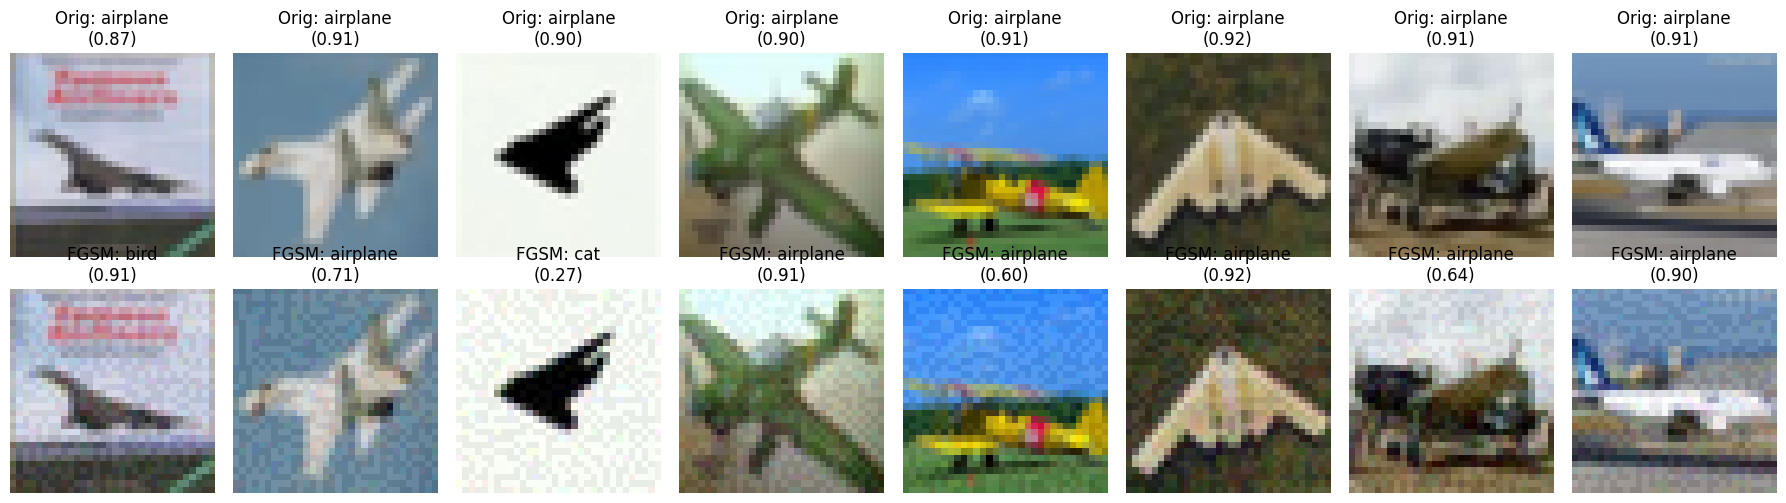


=== PGD : airplane → horse ===
Total airplane images: 1000
Right misclassified (→ horse): 595  (59.50%)
Wrong misclassified (→ other): 198  (19.80%)
Unchanged (still airplane):   207  (20.70%)
Targeted success among originally-correct airplanes: 567/960 (59.06%)
[Saved] adv_grid_pgd.png


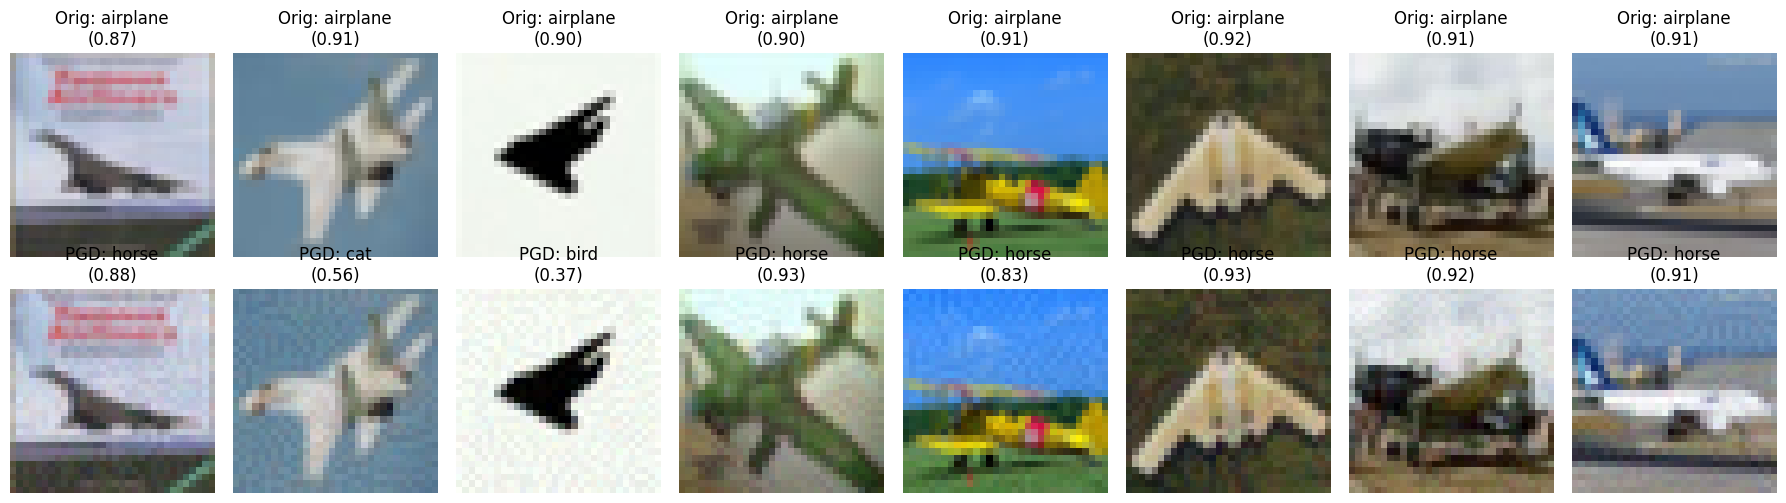

In [8]:
#!/usr/bin/env python3
# attack_eval_both.py
"""
Run targeted FGSM and targeted PGD (L∞) to misclassify CIFAR-10 'airplane' (0) as 'horse' (7).
- Loads your CIFARResNet from a checkpoint (best.pth or checkpoint.pth).
- Evaluates each attack independently on all airplane images in the test set.
- Prints:
    Right misclassified (→ horse), Wrong misclassified (→ other), Unchanged (still airplane),
    and targeted success among originally-correct airplanes.
- Saves visuals: adv_grid_fgsm.png, adv_grid_pgd.png
"""

import os, math, argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Model: Basic Residual Block and ResNet (exactly as in your code)
# -------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Identity()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CIFARResNet(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[2,2,2,2], num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64,  num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        layers.append(block(self.in_planes, planes, stride))
        self.in_planes = planes * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))        # (B,64,32,32)
        out = self.layer1(out)                       # (B,64,32,32)
        out = self.layer2(out)                       # (B,128,16,16)
        out = self.layer3(out)                       # (B,256,8,8)
        out = self.layer4(out)                       # (B,512,4,4)
        out = self.avgpool(out)                      # (B,512,1,1)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# -------------------------
# Argparse (safe for notebooks)
# -------------------------
def get_args():
    p = argparse.ArgumentParser("Targeted FGSM & PGD (airplane -> horse)")
    p.add_argument("--ckpt", type=str, default="./checkpoints/best.pth", help="path to .pth (best.pth or checkpoint.pth)")
    p.add_argument("--batch-size", type=int, default=128)
    p.add_argument("--eps", type=float, default=8, help="epsilon in /255 units (e.g., 8 => 8/255)")
    p.add_argument("--alpha", type=float, default=2, help="PGD step size in /255 units")
    p.add_argument("--steps", type=int, default=10, help="PGD steps")
    p.add_argument("--maxviz", type=int, default=8, help="images per visual grid")
    p.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    args, _ = p.parse_known_args()   # <-- ignore Jupyter's hidden --f=...
    return args

# -------------------------
# CIFAR-10 constants
# -------------------------
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
AIRPLANE, HORSE = 0, 7
MEAN_CPU = (0.4914, 0.4822, 0.4465)
STD_CPU  = (0.2023, 0.1994, 0.2010)

# Globals (created on device at runtime)
MEAN = None
STD  = None

# -------------------------
# Normalize / denormalize
# -------------------------
def normalize(x):   # x in [0,1]
    return (x - MEAN) / STD

def denormalize(x):  # -> [0,1]
    return torch.clamp(x * STD + MEAN, 0.0, 1.0)

# -------------------------
# Load model
# -------------------------
def load_model(ckpt_path, device):
    model = CIFARResNet().to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    state = ckpt.get("model_state", ckpt)  # support raw state_dict or wrapped {model_state,...}
    model.load_state_dict(state)
    model.eval()
    return model

@torch.no_grad()
def predict(model, x_norm):
    logits = model(x_norm)
    prob = F.softmax(logits, dim=1)
    conf, pred = prob.max(dim=1)
    return pred, conf, prob

# -------------------------
# Targeted attacks
# -------------------------
def targeted_fgsm(model, x_norm, target_labels, epsilon):
    """
    Craft in pixel space [0,1] for clear eps units; model sees normalized.
    Targeted => gradient sign is SUBTRACTED.
    """
    x = denormalize(x_norm).clone().detach().requires_grad_(True)  # [0,1]
    logits = model(normalize(x))
    loss = F.cross_entropy(logits, target_labels)
    model.zero_grad(set_to_none=True)
    loss.backward()
    x_adv = x - epsilon * x.grad.sign()
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return normalize(x_adv).detach()

def targeted_pgd_linf(model, x_norm, target_labels, eps, alpha, steps):
    x0 = denormalize(x_norm).clone().detach()      # [0,1]
    x_adv = x0.clone().detach()
    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits = model(normalize(x_adv))
        loss = F.cross_entropy(logits, target_labels)
        model.zero_grad(set_to_none=True)
        loss.backward()
        # targeted step toward target
        x_adv = x_adv - alpha * x_adv.grad.sign()
        # project to L∞ ball and clip to [0,1]
        x_adv = torch.clamp(x_adv, x0 - eps, x0 + eps)
        x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()
    return normalize(x_adv)

# -------------------------
# Metrics & visuals
# -------------------------
def compute_metrics(attack_name, model, x_norm, adv_x_norm, orig_pred):
    with torch.no_grad():
        adv_pred, adv_conf, _ = predict(model, adv_x_norm)

    total = x_norm.size(0)
    right_mis = (adv_pred == HORSE).sum().item()
    wrong_mis = ((adv_pred != AIRPLANE) & (adv_pred != HORSE)).sum().item()
    unchanged = (adv_pred == AIRPLANE).sum().item()

    # targeted success among originally-correct airplanes
    orig_correct_mask = (orig_pred == AIRPLANE)
    n_orig_correct = orig_correct_mask.sum().item()
    right_mis_from_correct = ((adv_pred == HORSE) & orig_correct_mask).sum().item() if n_orig_correct > 0 else 0

    print(f"\n=== {attack_name} : airplane → horse ===")
    print(f"Total airplane images: {total}")
    print(f"Right misclassified (→ horse): {right_mis}  ({right_mis/total*100:.2f}%)")
    print(f"Wrong misclassified (→ other): {wrong_mis}  ({wrong_mis/total*100:.2f}%)")
    print(f"Unchanged (still airplane):   {unchanged}  ({unchanged/total*100:.2f}%)")
    if n_orig_correct > 0:
        print(f"Targeted success among originally-correct airplanes: "
              f"{right_mis_from_correct}/{n_orig_correct} "
              f"({right_mis_from_correct/max(1,n_orig_correct)*100:.2f}%)")

    return adv_pred, adv_conf

def make_grid_visual(tag, orig_x_norm, adv_x_norm, orig_pred, adv_pred, orig_conf, adv_conf, max_items=8, out_path=None):
    n = min(max_items, orig_x_norm.size(0))
    orig = denormalize(orig_x_norm[:n]).cpu().permute(0,2,3,1).numpy()
    adv  = denormalize(adv_x_norm[:n]).cpu().permute(0,2,3,1).numpy()

    fig_w = 2.4 * n
    fig, axes = plt.subplots(2, n, figsize=(min(fig_w, 18), 5))
    if n == 1:
        axes = np.array([[axes[0]],[axes[1]]])

    for i in range(n):
        axes[0, i].imshow(orig[i])
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Orig: {CLASS_NAMES[orig_pred[i].item()]}\n({orig_conf[i].item():.2f})")

        axes[1, i].imshow(adv[i])
        axes[1, i].axis('off')
        axes[1, i].set_title(f"{tag}: {CLASS_NAMES[adv_pred[i].item()]}\n({adv_conf[i].item():.2f})")

    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=160, bbox_inches="tight")
        print(f"[Saved] {out_path}")
    plt.show()

# -------------------------
# Main
# -------------------------
def main():
    args = get_args()
    device = torch.device(args.device)

    # per-device mean/std tensors
    global MEAN, STD
    MEAN = torch.tensor(MEAN_CPU, device=device).view(1,3,1,1)
    STD  = torch.tensor(STD_CPU,  device=device).view(1,3,1,1)

    eps   = args.eps / 255.0
    alpha = args.alpha / 255.0

    # Data: CIFAR-10 test set (normalized)
    test_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(MEAN_CPU, STD_CPU),
    ])
    test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Collect ONLY airplane images
    xs, ys = [], []
    for x, y in test_loader:
        m = (y == AIRPLANE)
        if m.any():
            xs.append(x[m])
            ys.append(y[m])
    x_air = torch.cat(xs).to(device)     # normalized
    y_air = torch.cat(ys).to(device)
    print(f"Total airplane test images: {x_air.size(0)}")

    # Load model & baseline predictions
    model = load_model(args.ckpt, device)
    with torch.no_grad():
        orig_pred, orig_conf, _ = predict(model, x_air)

    # Target labels: all 'horse'
    target_labels = torch.full_like(y_air, HORSE)

    # 1) Targeted FGSM (independent run)
    x_adv_fgsm = targeted_fgsm(model, x_air, target_labels, eps)
    adv_pred_fgsm, adv_conf_fgsm = compute_metrics("FGSM", model, x_air, x_adv_fgsm, orig_pred)
    make_grid_visual("FGSM", x_air, x_adv_fgsm, orig_pred, adv_pred_fgsm, orig_conf, adv_conf_fgsm,
                     max_items=args.maxviz, out_path="adv_grid_fgsm.png")

    # 2) Targeted PGD (independent run)
    x_adv_pgd = targeted_pgd_linf(model, x_air, target_labels, eps, alpha, args.steps)
    adv_pred_pgd, adv_conf_pgd = compute_metrics("PGD", model, x_air, x_adv_pgd, orig_pred)
    make_grid_visual("PGD", x_air, x_adv_pgd, orig_pred, adv_pred_pgd, orig_conf, adv_conf_pgd,
                     max_items=args.maxviz, out_path="adv_grid_pgd.png")

if __name__ == "__main__":
    main()


In [9]:
def cw_targeted_loss(logits, target, kappa=0.0):
    """
    Lower is better for the target. Standard CW targeted loss:
      max( max_{j!=t} z_j - z_t, -kappa )
    We minimize this (so we push z_t above others by margin kappa).
    """
    num_classes = logits.size(1)
    onehot = F.one_hot(target, num_classes=num_classes).bool()
    z_t = logits[onehot]                                   # (B,)
    z_others = logits.clone()
    z_others[onehot] = -1e9                                # mask target
    z_max_other, _ = z_others.max(dim=1)                   # (B,)
    loss = torch.clamp(z_max_other - z_t, min=-kappa)      # (B,)
    return loss.mean()


In [10]:
def targeted_pgd_strong(model, x_norm, target_labels, eps, alpha, steps,
                        restarts=5, momentum_mu=0.9, use_cw=True, kappa=0.0,
                        early_stop=False):
    """
    Strong targeted PGD (L∞) with:
      - random starts (restarts)
      - momentum (MI-PGD)
      - CW/logit-margin loss (default) or CE
      - early stopping when all hit target
    Returns the *best* adversarial examples by target confidence.
    """
    device = x_norm.device
    x0 = denormalize(x_norm).detach()    # [0,1]

    best_adv = None
    best_conf = torch.full((x_norm.size(0),), -1.0, device=device)

    for r in range(restarts):
        # Random start in the L∞ ball
        delta = torch.empty_like(x0).uniform_(-eps, eps)
        x_adv = torch.clamp(x0 + delta, 0.0, 1.0).detach()
        grad_mom = torch.zeros_like(x_adv)

        for _ in range(steps):
            x_adv.requires_grad_(True)
            logits = model(normalize(x_adv))
            if use_cw:
                loss = cw_targeted_loss(logits, target_labels, kappa=kappa)
            else:
                loss = F.cross_entropy(logits, target_labels)  # targeted (minimize to target)

            model.zero_grad(set_to_none=True)
            loss.backward()

            # Normalize grad (as in MI-FGSM) + momentum
            g = x_adv.grad
            g = g / (g.abs().mean(dim=(1,2,3), keepdim=True) + 1e-12)
            grad_mom = momentum_mu * grad_mom + g.sign()

            # targeted step: descend toward target (subtract)
            x_adv = x_adv - alpha * grad_mom.sign()
            # project & clip
            x_adv = torch.max(torch.min(x_adv, x0 + eps), x0 - eps)
            x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()

        # evaluate target confidence after this restart
        with torch.no_grad():
            logits = model(normalize(x_adv))
            prob = F.softmax(logits, dim=1)
            conf_target = prob[torch.arange(prob.size(0), device=device), target_labels]

            # keep example if this restart improved target confidence
            take = conf_target > best_conf
            if take.any():
                if best_adv is None:
                    best_adv = x_adv.clone()
                else:
                    best_adv[take] = x_adv[take]
                best_conf[take] = conf_target[take]

        if early_stop and (best_conf > 0.5).all():  # tweak threshold if you like
            break

    # Fallback: if none improved, return last x_adv
    if best_adv is None:
        best_adv = x_adv
    return normalize(best_adv).detach()


In [13]:
# 1. Make sure your model class + normalize/denormalize functions are defined here
# (Reuse from your attack_eval_both.py script)

# 2. Load the model from your best checkpoint
CKPT_PATH = "./checkpoints/best.pth"  # adjust if needed
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = CIFARResNet().to(device)
ckpt = torch.load(CKPT_PATH, map_location=device)
state = ckpt.get("model_state", ckpt)
model.load_state_dict(state)
model.eval()

# 3. Load the test set and filter for airplanes
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

MEAN_CPU = (0.4914, 0.4822, 0.4465)
STD_CPU  = (0.2023, 0.1994, 0.2010)
MEAN = torch.tensor(MEAN_CPU, device=device).view(1,3,1,1)
STD  = torch.tensor(STD_CPU,  device=device).view(1,3,1,1)

def normalize(x): return (x - MEAN) / STD
def denormalize(x): return torch.clamp(x * STD + MEAN, 0.0, 1.0)

AIRPLANE, HORSE = 0, 7

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_CPU, STD_CPU),
])
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

x_air_list, y_air_list = [], []
for imgs, lbls in test_loader:
    mask = (lbls == AIRPLANE)
    if mask.any():
        x_air_list.append(imgs[mask])
        y_air_list.append(lbls[mask])
x_air = torch.cat(x_air_list).to(device)  # normalized
y_air = torch.cat(y_air_list).to(device)

print(f"Airplane samples: {x_air.shape[0]}")

# 4. Define the CW loss + strong PGD
import torch.nn.functional as F

def cw_targeted_loss(logits, target, kappa=0.0):
    num_classes = logits.size(1)
    onehot = F.one_hot(target, num_classes=num_classes).bool()
    z_t = logits[onehot]
    z_others = logits.clone()
    z_others[onehot] = -1e9
    z_max_other, _ = z_others.max(dim=1)
    loss = torch.clamp(z_max_other - z_t, min=-kappa)
    return loss.mean()

def targeted_pgd_strong(model, x_norm, target_labels, eps, alpha, steps,
                        restarts=5, momentum_mu=0.9, use_cw=True, kappa=0.0):
    device = x_norm.device
    x0 = denormalize(x_norm).detach()
    best_adv = None
    best_conf = torch.full((x_norm.size(0),), -1.0, device=device)

    for _ in range(restarts):
        delta = torch.empty_like(x0).uniform_(-eps, eps)
        x_adv = torch.clamp(x0 + delta, 0.0, 1.0).detach()
        grad_mom = torch.zeros_like(x_adv)

        for _ in range(steps):
            x_adv.requires_grad_(True)
            logits = model(normalize(x_adv))
            loss = cw_targeted_loss(logits, target_labels, kappa) if use_cw else F.cross_entropy(logits, target_labels)
            model.zero_grad(set_to_none=True)
            loss.backward()
            g = x_adv.grad
            g = g / (g.abs().mean(dim=(1,2,3), keepdim=True) + 1e-12)
            grad_mom = momentum_mu * grad_mom + g.sign()
            x_adv = x_adv - alpha * grad_mom.sign()
            x_adv = torch.max(torch.min(x_adv, x0 + eps), x0 - eps)
            x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()

        with torch.no_grad():
            logits = model(normalize(x_adv))
            prob = F.softmax(logits, dim=1)
            conf_target = prob[torch.arange(prob.size(0), device=device), target_labels]
            take = conf_target > best_conf
            if take.any():
                if best_adv is None:
                    best_adv = x_adv.clone()
                else:
                    best_adv[take] = x_adv[take]
                best_conf[take] = conf_target[take]

    if best_adv is None:
        best_adv = x_adv
    return normalize(best_adv).detach()

# 5. Run the stronger PGD
EPS   = 16/255
ALPHA = 2/255
STEPS = 40
RESTARTS = 5
MU = 0.9
KAPPA = 0.0

target_labels = torch.full_like(y_air, HORSE)
x_adv_strong = targeted_pgd_strong(model, x_air, target_labels, eps=EPS, alpha=ALPHA, steps=STEPS,
                                   restarts=RESTARTS, momentum_mu=MU, use_cw=True, kappa=KAPPA)

# 6. Measure targeted success
@torch.no_grad()
def predict(model, x_norm):
    logits = model(x_norm)
    prob = F.softmax(logits, dim=1)
    conf, pred = prob.max(dim=1)
    return pred, conf

orig_pred, _ = predict(model, x_air)
adv_pred, _  = predict(model, x_adv_strong)

total = x_air.size(0)
right_mis = (adv_pred == HORSE).sum().item()
wrong_mis = ((adv_pred != AIRPLANE) & (adv_pred != HORSE)).sum().item()
unchanged = (adv_pred == AIRPLANE).sum().item()

print(f"Right misclassified (→ horse): {right_mis} ({right_mis/total*100:.2f}%)")
print(f"Wrong misclassified (→ other): {wrong_mis} ({wrong_mis/total*100:.2f}%)")
print(f"Unchanged (still airplane): {unchanged} ({unchanged/total*100:.2f}%)")


Airplane samples: 1000
Right misclassified (→ horse): 992 (99.20%)
Wrong misclassified (→ other): 7 (0.70%)
Unchanged (still airplane): 1 (0.10%)


Airplane samples collected: 1000

=== FGSM : airplane → horse ===
Total: 1000
Right misclassified (→ horse): 33 (3.30%)
Wrong misclassified (→ other): 395 (39.50%)
Unchanged (still airplane):   572 (57.20%)
Targeted success among originally-correct: 31/960 (3.23%)

=== PGD-STRONG : airplane → horse ===
Total: 1000
Right misclassified (→ horse): 998 (99.80%)
Wrong misclassified (→ other): 2 (0.20%)
Unchanged (still airplane):   0 (0.00%)
Targeted success among originally-correct: 958/960 (99.79%)

Saved images under: saved_imgs
CSV manifest: saved_imgs/manifest.csv


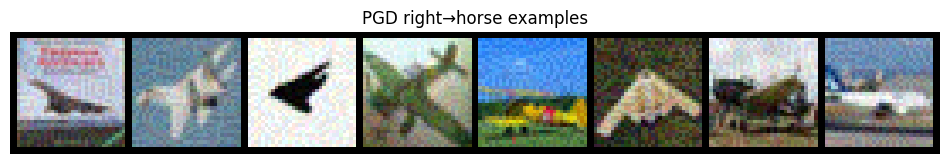

In [14]:
import os
import csv
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ---------- config ----------
CKPT_PATH = "./checkpoints/best.pth"   # your best.pth
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
BATCH_SIZE = 128
AIRPLANE, HORSE = 0, 7
MEAN_CPU = (0.4914, 0.4822, 0.4465)
STD_CPU  = (0.2023, 0.1994, 0.2010)

# FGSM params
EPS_FGSM = 8/255

# Strong PGD params (targeted, CW loss, momentum, multi-restart)
EPS_PGD   = 16/255
ALPHA_PGD = 2/255
STEPS_PGD = 40
RESTARTS  = 5
MU        = 0.9
KAPPA     = 0.0

# ---------- helpers ----------
MEAN = torch.tensor(MEAN_CPU, device=DEVICE).view(1,3,1,1)
STD  = torch.tensor(STD_CPU,  device=DEVICE).view(1,3,1,1)

def normalize(x):   # x in [0,1]
    return (x - MEAN) / STD

def denormalize(x): # clip to [0,1]
    return torch.clamp(x * STD + MEAN, 0.0, 1.0)

@torch.no_grad()
def predict(model, x_norm):
    logits = model(x_norm)
    prob = F.softmax(logits, dim=1)
    conf, pred = prob.max(dim=1)
    return pred, conf, prob

def targeted_fgsm(model, x_norm, target_labels, epsilon):
    x = denormalize(x_norm).clone().detach().requires_grad_(True)  # craft in [0,1]
    logits = model(normalize(x))
    loss = F.cross_entropy(logits, target_labels)
    model.zero_grad(set_to_none=True)
    loss.backward()
    x_adv = x - epsilon * x.grad.sign()   # targeted => subtract
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    return normalize(x_adv).detach()

# (Paste your cw_targeted_loss and targeted_pgd_strong if not already defined above)
def cw_targeted_loss(logits, target, kappa=0.0):
    num_classes = logits.size(1)
    onehot = F.one_hot(target, num_classes=num_classes).bool()
    z_t = logits[onehot]
    z_others = logits.clone()
    z_others[onehot] = -1e9
    z_max_other, _ = z_others.max(dim=1)
    loss = torch.clamp(z_max_other - z_t, min=-kappa)
    return loss.mean()

def targeted_pgd_strong(model, x_norm, target_labels, eps, alpha, steps,
                        restarts=5, momentum_mu=0.9, use_cw=True, kappa=0.0):
    device = x_norm.device
    x0 = denormalize(x_norm).detach()
    best_adv = None
    best_conf = torch.full((x_norm.size(0),), -1.0, device=device)

    for _ in range(restarts):
        delta = torch.empty_like(x0).uniform_(-eps, eps)
        x_adv = torch.clamp(x0 + delta, 0.0, 1.0).detach()
        grad_mom = torch.zeros_like(x_adv)

        for _ in range(steps):
            x_adv.requires_grad_(True)
            logits = model(normalize(x_adv))
            loss = cw_targeted_loss(logits, target_labels, kappa) if use_cw else F.cross_entropy(logits, target_labels)
            model.zero_grad(set_to_none=True)
            loss.backward()
            g = x_adv.grad
            g = g / (g.abs().mean(dim=(1,2,3), keepdim=True) + 1e-12)
            grad_mom = momentum_mu * grad_mom + g.sign()
            x_adv = x_adv - alpha * grad_mom.sign()  # targeted step
            x_adv = torch.max(torch.min(x_adv, x0 + eps), x0 - eps)
            x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()

        with torch.no_grad():
            logits = model(normalize(x_adv))
            prob = F.softmax(logits, dim=1)
            conf_target = prob[torch.arange(prob.size(0), device=device), target_labels]
            take = conf_target > best_conf
            if take.any():
                if best_adv is None:
                    best_adv = x_adv.clone()
                else:
                    best_adv[take] = x_adv[take]
                best_conf[take] = conf_target[take]

    if best_adv is None:
        best_adv = x_adv
    return normalize(best_adv).detach()

def save_tensor_as_png(img_norm, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    img = denormalize(img_norm.unsqueeze(0)).squeeze(0).cpu()  # [3,H,W] in [0,1]
    vutils.save_image(img, path)

# ---------- load model ----------
model = CIFARResNet().to(DEVICE)
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
state = ckpt.get("model_state", ckpt)
model.load_state_dict(state)
model.eval()

# ---------- load test set with indices ----------
# We wrap CIFAR10 to expose dataset indices while iterating
class IndexedCIFAR10(datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, target, index  # add original index

test_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(MEAN_CPU, STD_CPU)])
test_set = IndexedCIFAR10(root="./data", train=False, download=True, transform=test_tf)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# collect only airplanes along with original indices
x_list, y_list, idx_list = [], [], []
for imgs, lbls, idxs in test_loader:
    mask = (lbls == AIRPLANE)
    if mask.any():
        x_list.append(imgs[mask])
        y_list.append(lbls[mask])
        idx_list.append(idxs[mask])

x_air = torch.cat(x_list).to(DEVICE)   # normalized
y_air = torch.cat(y_list).to(DEVICE)
idx_air = torch.cat(idx_list)          # keep on CPU (indices)
print(f"Airplane samples collected: {x_air.size(0)}")

# ---------- clean preds ----------
orig_pred, orig_conf, _ = predict(model, x_air)

# ---------- attacks ----------
target_labels = torch.full_like(y_air, HORSE)

# FGSM
x_adv_fgsm = targeted_fgsm(model, x_air, target_labels, EPS_FGSM)
adv_pred_fgsm, adv_conf_fgsm, _ = predict(model, x_adv_fgsm)

# strong PGD
x_adv_pgd = targeted_pgd_strong(model, x_air, target_labels,
                                eps=EPS_PGD, alpha=ALPHA_PGD, steps=STEPS_PGD,
                                restarts=RESTARTS, momentum_mu=MU, use_cw=True, kappa=KAPPA)
adv_pred_pgd, adv_conf_pgd, _ = predict(model, x_adv_pgd)

# ---------- metrics print (optional) ----------
def print_metrics(tag, adv_pred):
    total = adv_pred.numel()
    right_mis = (adv_pred == HORSE).sum().item()
    wrong_mis = ((adv_pred != AIRPLANE) & (adv_pred != HORSE)).sum().item()
    unchanged = (adv_pred == AIRPLANE).sum().item()
    orig_correct_mask = (orig_pred == AIRPLANE)
    n_orig_correct = orig_correct_mask.sum().item()
    right_from_correct = ((adv_pred == HORSE) & orig_correct_mask).sum().item()
    print(f"\n=== {tag} : airplane → horse ===")
    print(f"Total: {total}")
    print(f"Right misclassified (→ horse): {right_mis} ({right_mis/total*100:.2f}%)")
    print(f"Wrong misclassified (→ other): {wrong_mis} ({wrong_mis/total*100:.2f}%)")
    print(f"Unchanged (still airplane):   {unchanged} ({unchanged/total*100:.2f}%)")
    if n_orig_correct > 0:
        print(f"Targeted success among originally-correct: {right_from_correct}/{n_orig_correct} ({right_from_correct/max(1,n_orig_correct)*100:.2f}%)")

print_metrics("FGSM", adv_pred_fgsm)
print_metrics("PGD-STRONG", adv_pred_pgd)

# ---------- save images + CSV ----------
base_dir = "saved_imgs"
csv_path = os.path.join(base_dir, "manifest.csv")
os.makedirs(base_dir, exist_ok=True)

# CSV header
rows = [["orig_index","attack","true_label","clean_pred","adv_pred","adv_conf","save_path"]]

def dump_set(tag, x_clean, x_adv, adv_pred, adv_conf):
    # three buckets
    right_mask = (adv_pred == HORSE)
    wrong_mask = ((adv_pred != AIRPLANE) & (adv_pred != HORSE))
    same_mask  = (adv_pred == AIRPLANE)

    def iter_bucket(mask, subdir):
        folder = os.path.join(base_dir, tag, subdir)
        os.makedirs(folder, exist_ok=True)
        # iterate tensors in this mask
        for i in torch.nonzero(mask, as_tuple=False).squeeze(1).tolist():
            idx = idx_air[i].item()
            adv_class = adv_pred[i].item()
            conf = adv_conf[i].item()
            save_path = os.path.join(folder, f"idx{idx}_adv{adv_class}_conf{conf:.2f}.png")
            # save ADV image
            save_tensor_as_png(x_adv[i], save_path)

            rows.append([
                idx,
                tag,
                AIRPLANE,                           # true label for all is airplane (0)
                orig_pred[i].item(),
                adv_class,
                round(conf, 6),
                save_path
            ])

    iter_bucket(right_mask, "right_to_horse")
    iter_bucket(wrong_mask, "wrong_to_other")
    iter_bucket(same_mask,  "unchanged_airplane")

dump_set("FGSM", x_air, x_adv_fgsm, adv_pred_fgsm, adv_conf_fgsm)
dump_set("PGD",  x_air, x_adv_pgd,  adv_pred_pgd,  adv_conf_pgd)

# write CSV
with open(csv_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(rows)
print(f"\nSaved images under: {base_dir}")
print(f"CSV manifest: {csv_path}")

# ---------- quick visual grid of right->horse (PGD) ----------
# pick up to 8 examples
right_idx = torch.nonzero(adv_pred_pgd == HORSE, as_tuple=False).squeeze(1)
if right_idx.numel() > 0:
    select = right_idx[:8]
    grid = denormalize(x_adv_pgd[select]).cpu()
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.imshow(np.transpose(vutils.make_grid(grid, nrow=min(8, grid.size(0)), padding=2).numpy(), (1,2,0)))
    ax.axis("off")
    ax.set_title("PGD right→horse examples")
    plt.show()
else:
    print("No PGD right→horse examples to visualize.")


In [17]:
# ---------------------------
# Image Upload
# ---------------------------
st.subheader("📤 Upload a CIFAR-10 image")
img_file = st.file_uploader(
    "PNG/JPG (any size will be resized to 32×32).",
    type=["png", "jpg", "jpeg"],
    key="image_uploader",
)

# If model not loaded, stop
if not model_ok:
    st.stop()

# If no image uploaded, stop cleanly
if img_file is None:
    st.info("Upload an image to begin.")
    st.stop()

# Try reading uploaded file safely
try:
    img_bytes = img_file.getvalue()
    image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
except Exception as e:
    st.error(f"Could not open image: {e}")
    st.stop()

# Convert to tensor
x01 = tensor_from_pil(image)  # (1,3,32,32) in [0,1]

# ---------------------------
# Predictions
# ---------------------------
with torch.inference_mode():
    pre_cls, pre_conf = predict(model, x01)

# Attack
if attack == "FGSM":
    x_adv = fgsm(model, x01, eps=eps)
else:
    x_adv = pgd_linf(model, x01, eps=eps, alpha=alpha, steps=steps, random_start=True)

with torch.inference_mode():
    post_cls, post_conf = predict(model, x_adv)

# ---------------------------
# Display
# ---------------------------
col1, col2, col3 = st.columns(3)

with col1:
    st.markdown("**Original**")
    st.image(pil_from_tensor01(x01), use_container_width=True)
    st.write("**Predicted:** ", pretty_pred(pre_cls, pre_conf))

with col2:
    st.markdown("**Adversarial**")
    st.image(pil_from_tensor01(x_adv), use_container_width=True)
    st.write("**Predicted:** ", pretty_pred(post_cls, post_conf))

with col3:
    st.markdown("**Perturbation (×10 for visibility)**")
    delta_vis = torch.clamp((x_adv - x01) * 10 + 0.5, 0.0, 1.0)
    st.image(pil_from_tensor01(delta_vis), use_container_width=True)
    linf = (x_adv - x01).abs().max().item()
    st.caption(f"L∞ distance: {linf:.4f}  (ε={eps:.4f})")

# Verdict
st.markdown("---")
st.subheader("🔍 Result")
if pre_cls != post_cls:
    st.success(
        f"Attack **succeeded**. Label changed from **{CIFAR10_CLASSES[pre_cls]}** "
        f"({pre_conf*100:.1f}%) to **{CIFAR10_CLASSES[post_cls]}** ({post_conf*100:.1f}%)."
    )
else:
    st.warning(
        f"Attack **failed**. Still **{CIFAR10_CLASSES[pre_cls]}** ({post_conf*100:.1f}%). "
        "Try larger ε or more PGD steps."
    )


2025-08-14 23:54:01.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 23:54:01.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 23:54:01.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 23:54:01.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 23:54:01.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 23:54:01.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 23:54:01.428 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-14 23:54:01.428 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

NameError: name 'image' is not defined